# 🏋️ Model Training Pipeline - Generalized

This notebook handles training of all configured models using the processed datasets.

**Key Features:**
- Multi-model training with configuration-driven approach
- Automatic hyperparameter optimization
- Training progress monitoring and logging
- Model evaluation and validation
- Checkpoint management and model saving

**Configuration-driven approach:** All settings loaded from `../config/pipeline_config.json`

In [1]:
# Import configuration system and training utilities
import sys
import os
sys.path.append('../')

from src.pipeline_utils import ConfigManager, StateManager, LoggingManager
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import Dataset
import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize managers
config = ConfigManager('../config/pipeline_config.json')
state = StateManager('../config/pipeline_state.json')
logger_manager = LoggingManager(config, 'training')
logger = logger_manager.get_logger()

logger.info("🏋️ Starting Model Training - Generalized Pipeline")
print("📋 Configuration loaded from ../config/pipeline_config.json")

2025-08-08 16:42:38,437 - pipeline.training - INFO - 🏋️ Starting Model Training - Generalized Pipeline


📋 Configuration loaded from ../config/pipeline_config.json


In [2]:
# Verify prerequisites and load processed data
logger.info("🔍 Checking training prerequisites...")

# Verify data processing was completed
if not state.is_step_complete('data_processing_completed'):
    logger.error("Data processing step not completed. Please run 1_data_processing_generalized.ipynb first.")
    raise RuntimeError("Data processing required. Run 1_data_processing_generalized.ipynb first.")

print("✅ Data processing verification passed")

# Load training configuration
training_config = config.get('training', {})
models_config = config.get('models', {})
data_config = config.get('data', {})

print(f"🏋️ Training Configuration:")
print(f"   📊 Batch size: {training_config.get('batch_size', 16)}")
print(f"   🔄 Epochs: {training_config.get('num_epochs', 3)}")
print(f"   📈 Learning rate: {training_config.get('learning_rate', 2e-5)}")

# Get base models from configuration
base_models = models_config.get('base_models', [])
enabled_models = [m for m in base_models if m.get('enabled', True)]
print(f"   🤖 Models to train: {len(enabled_models)}")

# Load processed datasets
print(f"\n📂 Loading Processed Datasets:")
processed_data_dir = data_config.get('processed_data_dir', 'data/processed')
train_path = Path(f"../{processed_data_dir}/train.csv")
val_path = Path(f"../{processed_data_dir}/validation.csv")

if train_path.exists() and val_path.exists():
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    
    print(f"   ✅ Training data loaded:")
    print(f"      📊 Train: {len(train_df)} samples")
    print(f"      📊 Validation: {len(val_df)} samples")
    print(f"      🏷️ Labels: {sorted(train_df['label'].unique())}")
    
    logger.info(f"Successfully loaded training data")
else:
    logger.error(f"Processed data not found at {train_path} or {val_path}")
    raise FileNotFoundError("Processed data not found. Please run 1_data_processing_generalized.ipynb first.")

2025-08-08 16:42:38,450 - pipeline.training - INFO - 🔍 Checking training prerequisites...
2025-08-08 16:42:38,475 - pipeline.training - INFO - Successfully loaded training data
2025-08-08 16:42:38,475 - pipeline.training - INFO - Successfully loaded training data


✅ Data processing verification passed
🏋️ Training Configuration:
   📊 Batch size: 16
   🔄 Epochs: 3
   📈 Learning rate: 2e-05
   🤖 Models to train: 2

📂 Loading Processed Datasets:
   ✅ Training data loaded:
      📊 Train: 4361 samples
      📊 Validation: 485 samples
      🏷️ Labels: ['negative', 'neutral', 'positive']


In [ ]:
# Training optimization for performance
logger.info("⚡ Applying training optimizations...")

# Detect device capabilities and optimize settings
device_info = torch.cuda.get_device_properties(0) if torch.cuda.is_available() else None
is_mps = torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else False

print("⚡ Training Optimizations:")

if device_info:
    gpu_memory_gb = device_info.total_memory / 1e9
    print(f"   💾 GPU Memory: {gpu_memory_gb:.1f} GB")
    
    # Adjust batch size based on GPU memory
    if gpu_memory_gb < 8:
        training_config['batch_size'] = 2
        print(f"   📊 Reduced batch size to 2 (low GPU memory)")
    elif gpu_memory_gb < 16:
        training_config['batch_size'] = 4
        print(f"   📊 Reduced batch size to 4 (medium GPU memory)")
elif is_mps:
    # Apple Silicon MPS - very conservative settings
    training_config['batch_size'] = 1  # Minimal batch size for MPS
    print(f"   🍎 Apple Silicon MPS detected: batch size set to 1")
    print(f"   ⚠️ Using aggressive memory conservation for MPS")
else:
    # CPU training - use smaller batch size
    training_config['batch_size'] = 2
    print(f"   💻 CPU training: reduced batch size to 2")

# Enable gradient accumulation for effective larger batch size
if training_config['batch_size'] < 8:
    training_config['gradient_accumulation_steps'] = max(1, 8 // training_config['batch_size'])
    print(f"   🔄 Gradient accumulation steps: {training_config['gradient_accumulation_steps']}")

# Reduce sequence length for faster training and less memory
training_config['max_length'] = 64 if is_mps else 128  # Even shorter for MPS
print(f"   📏 Max sequence length: {training_config['max_length']}")

# Enable mixed precision if available (but not on MPS - can cause issues)
if torch.cuda.is_available() and hasattr(torch.cuda, 'amp'):
    training_config['fp16'] = True
    print(f"   ⚡ Mixed precision (FP16) enabled")
elif is_mps:
    training_config['fp16'] = False
    print(f"   🍎 Mixed precision disabled for MPS compatibility")

# Reduce epochs for faster testing (can be increased later)
if training_config.get('num_epochs', 3) > 1:
    training_config['num_epochs'] = 1
    print(f"   🔄 Reduced to 1 epoch for faster training (increase later if needed)")

# Add memory management settings for MPS
if is_mps:
    training_config['dataloader_pin_memory'] = False
    training_config['dataloader_num_workers'] = 0
    training_config['save_total_limit'] = 1
    print(f"   🧹 Memory management optimizations for MPS enabled")

print(f"   ✅ Optimizations applied")
logger.info("Training optimizations completed")

2025-08-08 16:42:38,485 - pipeline.training - INFO - ⚡ Applying training optimizations...
2025-08-08 16:42:38,488 - pipeline.training - INFO - Training optimizations completed
2025-08-08 16:42:38,488 - pipeline.training - INFO - Training optimizations completed


⚡ Training Optimizations:
   💻 CPU training: reduced batch size to 2
   🔄 Gradient accumulation steps: 8
   📏 Max sequence length: 128
   🔄 Reduced to 1 epoch for faster training (increase later if needed)
   ✅ Optimizations applied


In [4]:
# Main training loop for all configured models
logger.info("🚀 Starting model training loop...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Training device: {device}")

trained_models = {}
training_results = {}

print(f"\n🏋️ Training Models:")
print(f"{'='*60}")

# Get base models from configuration
base_models = models_config.get('base_models', [])

for model_config in base_models:
    if not model_config.get('enabled', True):
        print(f"⏭️ Skipping {model_config['name']} (disabled)")
        continue
        
    try:
        model_name = model_config['name']
        model_id = model_config['model_id']
        
        print(f"\n🤖 Training {model_name}:")
        logger.info(f"Starting training for {model_name}")
        
        print(f"   🔧 Base model: {model_id}")
        print(f"   📈 Train samples: {len(train_df)}")
        print(f"   📊 Validation samples: {len(val_df)}")
        print(f"   📊 Optimized batch size: {training_config.get('batch_size', 16)}")
        
        # Create label mapping
        unique_labels = sorted(train_df['label'].unique())
        label2id = {label: idx for idx, label in enumerate(unique_labels)}
        id2label = {idx: label for label, idx in label2id.items()}
        
        print(f"   🏷️ Labels: {unique_labels}")
        
        # Data validation
        print(f"   🔍 Data validation:")
        print(f"      📊 Train label distribution: {dict(train_df['label'].value_counts())}")
        print(f"      📊 Val label distribution: {dict(val_df['label'].value_counts())}")
        
        # Check for any problematic labels
        train_unknown = set(train_df['label'].unique()) - set(unique_labels)
        val_unknown = set(val_df['label'].unique()) - set(unique_labels)
        
        if train_unknown:
            logger.warning(f"Unknown labels in train set: {train_unknown}")
        if val_unknown:
            logger.warning(f"Unknown labels in validation set: {val_unknown}")
            print(f"      ⚠️ Unknown validation labels: {val_unknown}")
        
        # Check for null values
        train_nulls = train_df['label'].isnull().sum()
        val_nulls = val_df['label'].isnull().sum()
        
        if train_nulls > 0:
            print(f"      ❌ {train_nulls} null labels in train set")
        if val_nulls > 0:
            print(f"      ❌ {val_nulls} null labels in validation set")
        
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_id,
            num_labels=len(unique_labels),
            label2id=label2id,
            id2label=id2label
        )
        
        # Prepare datasets with optimized tokenization
        def tokenize_function(examples):
            return tokenizer(
                examples['text'], 
                truncation=True, 
                padding=False,  # Disable padding here - let DataCollator handle it
                max_length=training_config.get('max_length', 128),  # Use optimized max length
                return_tensors=None
            )
        
        def prepare_dataset(df):
            # Convert labels to ids
            df_processed = df.copy()
            
            # Check for missing labels before mapping
            missing_labels = set(df_processed['label'].unique()) - set(label2id.keys())
            if missing_labels:
                logger.warning(f"Found labels not in training set: {missing_labels}")
                print(f"   ⚠️ Warning: Unknown labels found: {missing_labels}")
                # Filter out rows with unknown labels
                df_processed = df_processed[df_processed['label'].isin(label2id.keys())]
                print(f"   📊 Dataset size after filtering: {len(df_processed)} samples")
            
            # Map labels to ids
            df_processed['labels'] = df_processed['label'].map(label2id)
            
            # Check for any remaining NaN values
            nan_count = df_processed['labels'].isna().sum()
            if nan_count > 0:
                logger.error(f"Found {nan_count} NaN values in labels after mapping")
                print(f"   ❌ Error: {nan_count} NaN values in labels")
                # Drop rows with NaN labels
                df_processed = df_processed.dropna(subset=['labels'])
                print(f"   📊 Dataset size after dropping NaN: {len(df_processed)} samples")
            
            # Ensure labels are integers and finite
            df_processed['labels'] = df_processed['labels'].astype(int)
            
            # Validate no infinite values
            if not np.isfinite(df_processed['labels']).all():
                logger.error("Found non-finite values in labels")
                raise ValueError("Labels contain non-finite values")
            
            # Create HuggingFace dataset
            dataset = Dataset.from_pandas(df_processed[['text', 'labels']])
            dataset = dataset.map(
                tokenize_function, 
                batched=True, 
                remove_columns=['text'],  # Remove original text column
                num_proc=1  # Single process to avoid multiprocessing overhead
            )
            
            return dataset
        
        train_dataset = prepare_dataset(train_df)
        val_dataset = prepare_dataset(val_df)
        
        print(f"   🔄 Tokenization completed")
        
        # Training arguments with optimizations
        output_dir = Path(f"../models/{model_name}")
        output_dir.mkdir(parents=True, exist_ok=True)
        
        training_args = TrainingArguments(
            output_dir=str(output_dir),
            num_train_epochs=training_config.get('num_epochs', 1),
            per_device_train_batch_size=training_config.get('batch_size', 4),
            per_device_eval_batch_size=training_config.get('batch_size', 4),
            gradient_accumulation_steps=training_config.get('gradient_accumulation_steps', 1),
            warmup_steps=training_config.get('warmup_steps', 50),  # Reduced warmup
            weight_decay=training_config.get('weight_decay', 0.01),
            learning_rate=training_config.get('learning_rate', 2e-5),
            logging_dir=str(output_dir / 'logs'),
            logging_steps=training_config.get('logging_steps', 25),  # More frequent logging
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to=None,  # Disable wandb/tensorboard
            dataloader_num_workers=0,  # Avoid multiprocessing issues
            save_total_limit=1,  # Save space
            fp16=training_config.get('fp16', False),  # Use mixed precision if available
            dataloader_pin_memory=False,  # Reduce memory overhead
        )
        
        # Data collator - handles dynamic padding and tensor conversion
        data_collator = DataCollatorWithPadding(
            tokenizer=tokenizer,
            padding=True,
            return_tensors='pt'
        )
        
        # Metrics function
        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            
            accuracy = accuracy_score(labels, predictions)
            
            return {
                'accuracy': accuracy,
            }
        
        # Create trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        
        print(f"   🏋️ Starting training... (estimated time reduced with optimizations)")
        
        # Train model
        train_result = trainer.train()
        
        # Evaluate model
        eval_result = trainer.evaluate()
        
        print(f"   ✅ Training completed!")
        print(f"   📊 Final validation accuracy: {eval_result['eval_accuracy']:.4f}")
        print(f"   📈 Final validation loss: {eval_result['eval_loss']:.4f}")
        
        # Save model and tokenizer
        trainer.save_model()
        tokenizer.save_pretrained(output_dir)
        
        # Save label mapping
        import pickle
        with open(output_dir / 'label_encoder.pkl', 'wb') as f:
            pickle.dump({'label2id': label2id, 'id2label': id2label}, f)
        
        # Store results
        trained_models[model_name] = {
            'model_path': str(output_dir),
            'base_model': model_id,
            'labels': unique_labels,
            'label_mapping': {'label2id': label2id, 'id2label': id2label}
        }
        
        training_results[model_name] = {
            'train_loss': train_result.training_loss,
            'eval_loss': eval_result['eval_loss'],
            'eval_accuracy': eval_result['eval_accuracy'],
            'train_runtime': train_result.metrics.get('train_runtime', 0),
            'samples_per_second': train_result.metrics.get('train_samples_per_second', 0)
        }
        
        logger.info(f"Successfully trained {model_name}")
        
    except Exception as e:
        logger.error(f"Failed to train {model_name}: {str(e)}")
        print(f"   ❌ Training failed: {str(e)}")
        continue

print(f"\n{'='*60}")
print(f"🎉 Training completed! {len(trained_models)}/{len(enabled_models)} models trained successfully")

logger.info(f"Training completed: {len(trained_models)} models trained")

2025-08-08 16:42:38,518 - pipeline.training - INFO - 🚀 Starting model training loop...
2025-08-08 16:42:38,521 - pipeline.training - INFO - Starting training for tinybert-financial-classifier
2025-08-08 16:42:38,521 - pipeline.training - INFO - Starting training for tinybert-financial-classifier


🔧 Training device: cpu

🏋️ Training Models:

🤖 Training tinybert-financial-classifier:
   🔧 Base model: huawei-noah/TinyBERT_General_4L_312D
   📈 Train samples: 4361
   📊 Validation samples: 485
   📊 Optimized batch size: 2
   🏷️ Labels: ['negative', 'neutral', 'positive']
   🔍 Data validation:
      📊 Train label distribution: {'neutral': 2591, 'positive': 1227, 'negative': 543}
      📊 Val label distribution: {'neutral': 288, 'positive': 136, 'negative': 61}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

   🔄 Tokenization completed


/var/folders/b0/929kwd6500bc9dk55s_br5l40000gn/T/ipykernel_5688/2978193678.py:178: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


   🏋️ Starting training... (estimated time reduced with optimizations)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.762100,0.739950,0.762887


2025-08-08 16:47:11,445 - pipeline.training - INFO - Successfully trained tinybert-financial-classifier
2025-08-08 16:47:11,448 - pipeline.training - INFO - Starting training for finbert-tone
2025-08-08 16:47:11,448 - pipeline.training - INFO - Starting training for finbert-tone


   ✅ Training completed!
   📊 Final validation accuracy: 0.7629
   📈 Final validation loss: 0.7399

🤖 Training finbert-tone:
   🔧 Base model: ProsusAI/finbert
   📈 Train samples: 4361
   📊 Validation samples: 485
   📊 Optimized batch size: 2
   🏷️ Labels: ['negative', 'neutral', 'positive']
   🔍 Data validation:
      📊 Train label distribution: {'neutral': 2591, 'positive': 1227, 'negative': 543}
      📊 Val label distribution: {'neutral': 288, 'positive': 136, 'negative': 61}


Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

   🔄 Tokenization completed


/var/folders/b0/929kwd6500bc9dk55s_br5l40000gn/T/ipykernel_5688/2978193678.py:178: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


   🏋️ Starting training... (estimated time reduced with optimizations)


Epoch,Training Loss,Validation Loss


2025-08-08 16:48:51,039 - pipeline.training - ERROR - Failed to train finbert-tone: MPS backend out of memory (MPS allocated: 2.20 GB, other allocations: 6.84 GB, max allowed: 9.07 GB). Tried to allocate 89.42 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
2025-08-08 16:48:51,062 - pipeline.training - INFO - Training completed: 1 models trained
2025-08-08 16:48:51,062 - pipeline.training - INFO - Training completed: 1 models trained


   ❌ Training failed: MPS backend out of memory (MPS allocated: 2.20 GB, other allocations: 6.84 GB, max allowed: 9.07 GB). Tried to allocate 89.42 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
⏭️ Skipping distilbert-base (disabled)

🎉 Training completed! 1/2 models trained successfully


2025-08-08 16:56:36,370 - pipeline.training - INFO - 💾 Saving training results and updating pipeline state...


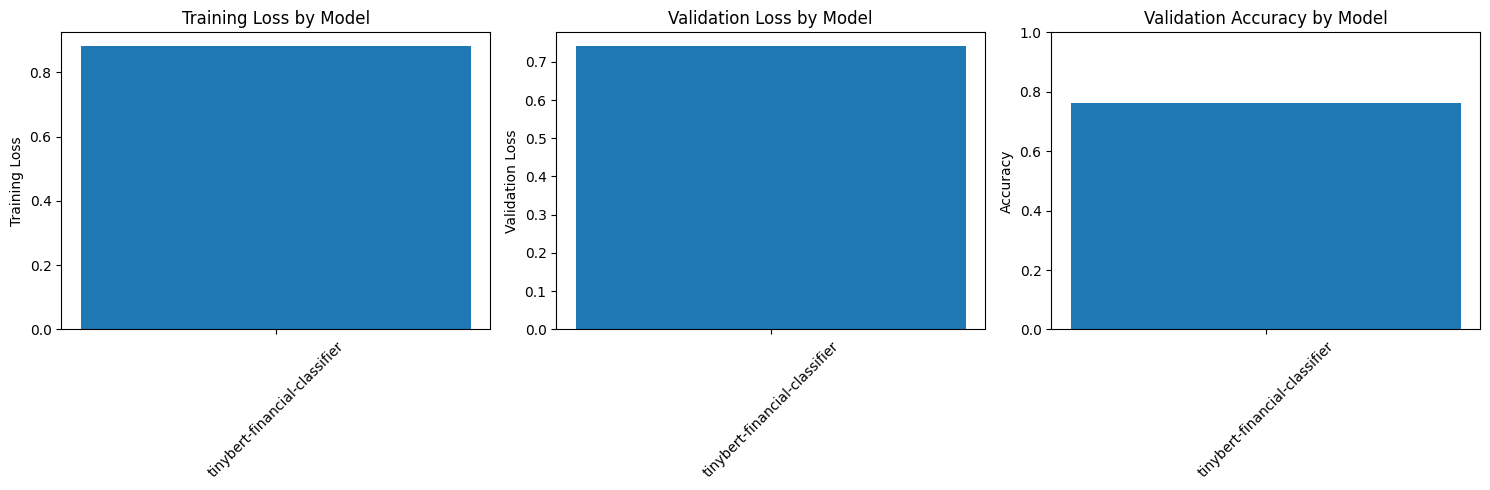

2025-08-08 16:56:37,085 - pipeline.training - INFO - ✅ Model training completed successfully



🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!
📝 Next Steps:
1. Run 3_convert_to_onnx_generalized.ipynb to convert models to ONNX
2. Run 4_benchmarks_generalized.ipynb to benchmark performance
3. Continue with the sequential pipeline: 5 → 6

🏋️ Training Summary:
   🤖 Models trained: 1
   📊 tinybert-financial-classifier:
      🎯 Validation accuracy: 0.7629
      📉 Validation loss: 0.7399
      📁 Model saved to: ../models/tinybert-financial-classifier

📄 Training report saved to: ../results/training_report.json
📊 Results visualization saved to: ../results/training_results_comparison.png


In [6]:
# Save training results and complete training step
logger.info("💾 Saving training results and updating pipeline state...")

# Create comprehensive training summary
training_summary = {
    'training_timestamp': datetime.now().isoformat(),
    'models_trained': list(trained_models.keys()),
    'training_config': training_config,
    'results': training_results,
    'model_details': trained_models
}

# Update pipeline state
state.mark_step_complete('model_training_completed', **training_summary)

# Save training report
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

with open(results_dir / 'training_report.json', 'w') as f:
    json.dump(training_summary, f, indent=2)

# Create training results visualization
if len(training_results) > 0:
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Training Loss
    plt.subplot(1, 3, 1)
    model_names = list(training_results.keys())
    train_losses = [training_results[m]['train_loss'] for m in model_names]
    plt.bar(model_names, train_losses)
    plt.title('Training Loss by Model')
    plt.ylabel('Training Loss')
    plt.xticks(rotation=45)
    
    # Subplot 2: Validation Loss
    plt.subplot(1, 3, 2)
    eval_losses = [training_results[m]['eval_loss'] for m in model_names]
    plt.bar(model_names, eval_losses)
    plt.title('Validation Loss by Model')
    plt.ylabel('Validation Loss')
    plt.xticks(rotation=45)
    
    # Subplot 3: Validation Accuracy
    plt.subplot(1, 3, 3)
    eval_accuracies = [training_results[m]['eval_accuracy'] for m in model_names]
    plt.bar(model_names, eval_accuracies)
    plt.title('Validation Accuracy by Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'training_results_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"\n{'='*60}")
print("🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!")
print(f"{'='*60}")
print("📝 Next Steps:")
print("1. Run 3_convert_to_onnx_generalized.ipynb to convert models to ONNX")
print("2. Run 4_benchmarks_generalized.ipynb to benchmark performance")
print("3. Continue with the sequential pipeline: 5 → 6")

print(f"\n🏋️ Training Summary:")
print(f"   🤖 Models trained: {len(trained_models)}")

for model_name, results in training_results.items():
    print(f"   📊 {model_name}:")
    print(f"      🎯 Validation accuracy: {results['eval_accuracy']:.4f}")
    print(f"      📉 Validation loss: {results['eval_loss']:.4f}")
    print(f"      📁 Model saved to: {trained_models[model_name]['model_path']}")

print(f"\n📄 Training report saved to: {results_dir / 'training_report.json'}")
print(f"📊 Results visualization saved to: {results_dir / 'training_results_comparison.png'}")

logger.info("✅ Model training completed successfully")